# MARL Training

*Adapted from https://github.com/tobiasbaumann1/amd*

In [1]:
import os, math, pickle, time, logging, warnings
from tqdm import tqdm
from enum import Enum
import numpy as np
import gym
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-paper')
sns.set_style("whitegrid")
plt.figsize = [10, 6]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["#70ABAF", "#F8764F", '#7fb800', '#F92A82']) 

import torch
import torch.nn as nn

In [2]:
N_EPISODES = 4000
N_ACTIONS = 2
N_PLAYERS = 2
N_UNITS = 10
MAX_REWARD_STRENGTH = 3
RANDOM_SEED = 8

# Define Environment

In [3]:
class Environment:
    def __init__(self):
        self.n_actions = N_ACTIONS
        self.n_players = N_PLAYERS
        self.n_features = 1
        self.episode_length = 1
        self.step_ctr = 0
        self.ep_ctr = 0
        self.actions_list = []
        self.avg_rewards_per_round = []        
        self.reset()

    def step(self, actions):
        self.actions_list.append(actions)
        rewards = self.calculate_payoffs(actions)
        self.stored_rewards[:,self.step_ctr] = rewards
        self.update_state(actions)
        self.step_ctr += 1
        return self.state_to_observation(), rewards, self.is_done()

    def reset(self):
        self.s = self.initial_state()
        self.actions_list = []
        self.step_ctr = 0
        self.stored_rewards = np.zeros((self.n_players,self.episode_length))
        self.ep_ctr += 1
        return self.state_to_observation()

    def reset_ep_ctr(self):
        self.ep_ctr = 0

    def state_to_observation(self):
        return self.s

    def update_state(self, actions):
        pass

    def initial_state(self):
        raise NotImplementedError

    def is_done(self):
        if self.step_ctr >= self.episode_length:
            self.avg_rewards_per_round.append(np.mean(self.stored_rewards,axis=1))
            return True
        else:
            return False

    def get_avg_rewards_per_round(self):
        return np.asarray(self.avg_rewards_per_round)

In [4]:
class MatrixGame(Environment):
    def __init__(self, fear, greed):
        self.fear = fear
        self.greed = greed
        self.R = 3
        self.P = 1
        self.T = self.R+self.greed
        self.S = self.P-self.fear
        super().__init__()

    def initial_state(self):
        return np.zeros(1) #dummy feature 

    def calculate_payoffs(self, actions):
        assert actions[0] == 1 or actions[0] == 0
        assert actions[1] == 1 or actions[1] == 0
        if actions[0] == 1: 
            if actions[1] == 0:
                return [self.S,self.T]
            else:
                return [self.R,self.R]
        else:
            if actions[1] == 0:
                return [self.P,self.P]
            else:
                return [self.T,self.S]

    def __str__(self):
        raise NotImplementedError
    
class IPD(MatrixGame):
    def __init__(self):
        super().__init__(fear=1, greed=1)
    
    def __str__(self):
        return 'IPD'
    
class StagHunt(MatrixGame):
    def __init__(self):
        super().__init__(fear=1, greed=-1)
    
    def __str__(self):
        return 'StagHunt'
    
class Chicken(MatrixGame):
    def __init__(self):
        super().__init__(fear=-1, greed=0.5)
    
    def __str__(self):
        return 'Chicken'

# Define Agents

In [5]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
warnings.filterwarnings("ignore")
import tensorflow as tf
np.random.seed(RANDOM_SEED)
tf.compat.v1.set_random_seed(RANDOM_SEED)
tf.compat.v1.disable_eager_execution()
class Agent:
    def __init__(self, env, learning_rate=0.001, gamma = 0.95, agent_idx = 0):
        self.sess = tf.compat.v1.Session()
        self.env = env
        self.n_actions = env.n_actions
        self.n_features = env.n_features
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.agent_idx = agent_idx
        self.log = [] # logs action probabilities

    def choose_action(self, s):
        action_probs = self.calc_action_probs(s)
        action = np.random.choice(range(action_probs.shape[1]), p=action_probs.ravel())  # select action w.r.t the actions prob
        self.log.append(action_probs[0,1])
        return action

    def learn_at_episode_end(self):
        pass

    def close(self):
        self.sess.close()
        tf.compat.v1.reset_default_graph()

    def reset(self):
        self.sess.run(tf.compat.v1.global_variables_initializer())

## Define Critic

In [6]:
class Critic_Variant(Enum):
    INDEPENDENT = 1
    CENTRALIZED = 2
    CENTRALIZED_APPROX = 3

class Critic(object):
    def __init__(self, env, n_units, learning_rate, gamma, agent_idx, 
                critic_variant = Critic_Variant.INDEPENDENT):
        self.critic_variant = critic_variant
        self.env = env

        self.s = tf.compat.v1.placeholder(tf.float32, [1, env.n_features], "state")
        self.v_ = tf.compat.v1.placeholder(tf.float32, [1, 1], "v_next")
        self.r = tf.compat.v1.placeholder(tf.float32, None, 'r')

        if self.critic_variant is Critic_Variant.CENTRALIZED:
            self.act_probs = tf.compat.v1.placeholder(tf.float32, shape=[1, env.n_actions * env.n_players], name="act_probs")
            self.nn_inputs = tf.concat([self.s,self.act_probs],axis=1)
        else: 
            self.nn_inputs = self.s

        with tf.compat.v1.variable_scope('Critic'):
            l1 = tf.compat.v1.layers.dense(
                inputs=self.nn_inputs,
                units=n_units,  # number of hidden units
                activation=tf.nn.relu,  # None
                kernel_initializer=tf.compat.v1.random_normal_initializer(0., .1),  # weights
                bias_initializer=tf.compat.v1.constant_initializer(0.1),  # biases
                name='l1'+str(agent_idx)
            )

            self.v = tf.compat.v1.layers.dense(
                inputs=l1,
                units=1,  # output units
                activation=None,
                kernel_initializer=tf.compat.v1.random_normal_initializer(0., .1),  # weights
                bias_initializer=tf.compat.v1.constant_initializer(0.1),  # biases
                name='V'+str(agent_idx)
            )

        with tf.compat.v1.variable_scope('squared_TD_error'):
            self.td_error = self.r + gamma * self.v_ - self.v
            self.loss = tf.square(self.td_error)
        with tf.compat.v1.variable_scope('trainCritic'):
            self.train_op = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(self.loss)

    def pass_agent_list(self, agent_list):
        self.agent_list = agent_list

    def learn(self, sess, s, r, s_, *args):
        s,s_ = s.astype(np.float32), s_.astype(np.float32)

        if self.critic_variant is Critic_Variant.CENTRALIZED:
            if args: 
                obslist = args[0]
                obs_list = args[1]
                act_probs = np.hstack([agent.calc_action_probs(obslist[idx]) for idx, agent in enumerate(self.agent_list)])
                act_probs_ = np.hstack([agent.calc_action_probs(obs_list[idx]) for idx, agent in enumerate(self.agent_list)])
            else: 
                act_probs = np.hstack([agent.calc_action_probs(s) for idx, agent in enumerate(self.agent_list)])
                act_probs_ = np.hstack([agent.calc_action_probs(s_) for idx, agent in enumerate(self.agent_list)])
            nn_inputs = np.hstack([s[np.newaxis, :], act_probs])
            nn_inputs_ = np.hstack([s_[np.newaxis, :], act_probs_])
        else:
            nn_inputs, nn_inputs_ = s[np.newaxis, :], s_[np.newaxis, :]

        v_ = sess.run(self.v, {self.nn_inputs: nn_inputs_})
        td_error, _ = sess.run([self.td_error, self.train_op],
                                          {self.nn_inputs: nn_inputs, self.v_: v_, self.r: r})
        return td_error

## Define Actor

In [7]:
class Simple_Agent(Agent): #plays games with 2 actions, using a single parameter
    def __init__(self, env, learning_rate=0.001, n_units_critic = 20, gamma = 0.95, agent_idx = 0, critic_variant = Critic_Variant.INDEPENDENT):
        super().__init__(env, learning_rate, gamma, agent_idx)
        self.s = tf.compat.v1.placeholder(tf.float32, [1, env.n_features], "state") # dummy variable
        self.a = tf.compat.v1.placeholder(tf.int32, None, "act")
        self.td_error = tf.compat.v1.placeholder(tf.float32, None, "td_error")  # TD_error

        with tf.compat.v1.variable_scope('Actor'):
            self.theta = tf.Variable(tf.random.normal([1],mean = -2, stddev=0.5)) 
            self.actions_prob = tf.expand_dims(tf.concat([1-tf.sigmoid(self.theta),tf.sigmoid(self.theta)],0),0)

        with tf.compat.v1.variable_scope('exp_v'):
            self.log_prob = tf.math.log(self.actions_prob[0,self.a])
            self.g_log_pi = tf.gradients(ys=self.log_prob,xs=self.theta)
            self.exp_v = tf.reduce_mean(input_tensor=self.log_prob * self.td_error)  

        with tf.compat.v1.variable_scope('trainActor'):
            self.train_op = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(-self.exp_v) 

        self.critic = Critic(env, n_units_critic, learning_rate, gamma, agent_idx, critic_variant)

        self.sess.run(tf.compat.v1.global_variables_initializer())

    def learn(self, s, a, r, s_, done = False, *args):
        if done:
            pass
        else:
            td = self.critic.learn(self.sess,s,r,s_, *args)
            feed_dict = {self.a: a, self.td_error: td}
            _, exp_v = self.sess.run([self.train_op, self.exp_v], feed_dict)

    def __str__(self):
        return 'Agent {}'.format(self.agent_idx)

    def calc_action_probs(self, s):
        s = s[np.newaxis, :]
        probs = self.sess.run(self.actions_prob)  
        return probs

    def pass_agent_list(self, agent_list):
        self.critic.pass_agent_list(agent_list)

    def get_state_variable(self):
        return self.s

    def calc_g_log_pi(self,s,a):
        return self.sess.run(self.g_log_pi,feed_dict={self.s:s,self.a:a})

## Define Planning Agent

In [8]:
class Planning_Agent(Agent):
    def __init__(self, env, underlying_agents, learning_rate=0.01,
        gamma = 0.95, cost_param = 0, with_redistribution = False, 
        value_fn_variant = 'exact', max_influence=MAX_REWARD_STRENGTH):
        super().__init__(env, learning_rate, gamma)
        self.underlying_agents = underlying_agents
        self.log = []
        n_players = len(underlying_agents)
        self.with_redistribution = with_redistribution
        self.value_fn_variant = value_fn_variant
        self.max_influence = max_influence

        self.s = tf.compat.v1.placeholder(tf.float32, [1, env.n_features], "state")   
        self.a_players = tf.compat.v1.placeholder(tf.float32, [1, n_players], "player_actions")
        if value_fn_variant == 'exact':
            self.p_players = tf.compat.v1.placeholder(tf.float32, [1, n_players], "player_action_probs")
            self.a_plan = tf.compat.v1.placeholder(tf.float32, [2, 2], "conditional_planning_actions") # works only for matrix games
        self.r_players = tf.compat.v1.placeholder(tf.float32, [1, n_players], "player_rewards")
        self.inputs = tf.concat([self.s,self.a_players],1)

        with tf.compat.v1.variable_scope('Policy_p'):
            self.l1 = tf.compat.v1.layers.dense(
                inputs=self.inputs,
                units=n_players,    # 1 output per agent
                activation=None,
                kernel_initializer=tf.compat.v1.random_normal_initializer(0, .1),  # weights
                bias_initializer=tf.compat.v1.random_normal_initializer(0, .1),  # biases
                name='actions_planning'
            )

            if self.max_influence is None:
                self.action_layer = self.l1
            else:
                self.action_layer = tf.sigmoid(self.l1)

        with tf.compat.v1.variable_scope('Vp'):
            # Vp is trivial to calculate in this special case
            if self.max_influence is not None:
                self.vp = 2 * self.max_influence * (self.action_layer - 0.5)
            else:
                self.vp = self.action_layer

        with tf.compat.v1.variable_scope('V_total'):
            if value_fn_variant == 'proxy':
                self.v = 2 * self.a_players - 1
            if value_fn_variant == 'estimated':
                self.v = tf.reduce_sum(input_tensor=self.r_players) - 1.9
        with tf.compat.v1.variable_scope('cost_function'):
            if value_fn_variant == 'estimated':
                self.g_log_pi = tf.compat.v1.placeholder(tf.float32, [1, n_players], "player_gradients")
            cost_list = []
            for underlying_agent in underlying_agents:
                # policy gradient theorem
                idx = underlying_agent.agent_idx
                if value_fn_variant == 'estimated':
                    self.g_Vp = self.g_log_pi[0,idx] * self.vp[0,idx]
                    self.g_V = self.g_log_pi[0,idx] * (self.v[0,idx] if value_fn_variant == 'proxy' else self.v)
                if value_fn_variant == 'exact':
                    self.g_p = self.p_players[0,idx] * (1-self.p_players[0,idx])
                    self.p_opp = self.p_players[0,1-idx]
                    self.g_Vp = self.g_p * tf.gradients(ys = self.vp[0,idx],xs = self.a_players)[0][0,idx]
                    self.g_V = self.g_p * (self.p_opp * (2 * env.R - env.T - env.S) 
                        + (1-self.p_opp) * (env.T + env.S - 2 * env.P))

                #cost_list.append(- underlying_agent.learning_rate * tf.tensordot(self.g_Vp,self.g_V,1))
                cost_list.append(- underlying_agent.learning_rate * self.g_Vp * self.g_V)

            if with_redistribution:
                extra_loss = cost_param * tf.norm(tensor=self.vp-tf.reduce_mean(input_tensor=self.vp))
            else:
                extra_loss = cost_param * tf.norm(tensor=self.vp)
            self.loss = tf.reduce_sum(input_tensor=tf.stack(cost_list)) + extra_loss

        with tf.compat.v1.variable_scope('trainPlanningAgent'):
            self.train_op = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(self.loss, 
                var_list = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES, scope='Policy_p'))  

        self.sess.run(tf.compat.v1.global_variables_initializer())

    def learn(self, s, a_players):
        s = s[np.newaxis,:]
        r_players = np.asarray(self.env.calculate_payoffs(a_players))
        a_players = np.asarray(a_players)
        feed_dict = {self.s: s, self.a_players: a_players[np.newaxis,:], 
                    self.r_players: r_players[np.newaxis,:]}
        if self.value_fn_variant == 'estimated':
            g_log_pi_list = []
            for underlying_agent in self.underlying_agents:
                idx = underlying_agent.agent_idx
                g_log_pi_list.append(underlying_agent.calc_g_log_pi(s,a_players[idx]))
            g_log_pi_arr = np.reshape(np.asarray(g_log_pi_list),[1,-1])
            feed_dict[self.g_log_pi] = g_log_pi_arr
        if self.value_fn_variant == 'exact':
            p_players_list = []
            for underlying_agent in self.underlying_agents:
                idx = underlying_agent.agent_idx
                p_players_list.append(underlying_agent.calc_action_probs(s)[0,-1])
            p_players_arr = np.reshape(np.asarray(p_players_list),[1,-1])
            feed_dict[self.p_players] = p_players_arr
            feed_dict[self.a_plan] = self.calc_conditional_planning_actions(s)
        self.sess.run([self.train_op], feed_dict)

        action,loss,g_Vp,g_V = self.sess.run([self.action_layer,self.loss,
            self.g_Vp,self.g_V], feed_dict)
        logging.info('Learning step')
        logging.info('Planning_action: ' + str(action))
        if self.value_fn_variant == 'estimated':
            vp,v = self.sess.run([self.vp,self.v],feed_dict)
            logging.info('Vp: ' + str(vp))
            logging.info('V: ' + str(v))
        logging.info('Gradient of V_p: ' + str(g_Vp))
        logging.info('Gradient of V: ' + str(g_V))
        logging.info('Loss: ' + str(loss))

    def get_log(self):
        return np.array(self.log)

    def choose_action(self, s, a_players):
        logging.info('Player actions: ' + str(a_players))
        s = s[np.newaxis, :]
        a_players = np.asarray(a_players)        
        a_plan = self.sess.run(self.action_layer, {self.s: s, self.a_players: a_players[np.newaxis,:]})[0,:]
        if self.max_influence is not None:
            a_plan = 2 * self.max_influence * (a_plan - 0.5)
        logging.info('Planning action: ' + str(a_plan))
        self.log.append(self.calc_conditional_planning_actions(s))
        return a_plan

    def calc_conditional_planning_actions(self,s):
        # Planning actions in each of the 4 cases: DD, CD, DC, CC
        a_plan_DD = self.sess.run(self.action_layer, {self.s: s, self.a_players: np.array([0,0])[np.newaxis,:]})
        a_plan_CD = self.sess.run(self.action_layer, {self.s: s, self.a_players: np.array([1,0])[np.newaxis,:]})
        a_plan_DC = self.sess.run(self.action_layer, {self.s: s, self.a_players: np.array([0,1])[np.newaxis,:]})
        a_plan_CC = self.sess.run(self.action_layer, {self.s: s, self.a_players: np.array([1,1])[np.newaxis,:]})
        l_temp = [a_plan_DD,a_plan_CD,a_plan_DC,a_plan_CC]
        if self.max_influence is not None:
            l = [2 * self.max_influence * (a_plan_X[0,0]-0.5) for a_plan_X in l_temp]
        else:
            l = [a_plan_X[0,0] for a_plan_X in l_temp]
        if self.with_redistribution:
            if self.max_influence is not None:
                l2 = [2 * self.max_influence * (a_plan_X[0,1]-0.5) for a_plan_X in l_temp]
            else:
                l2 = [a_plan_X[0,1] for a_plan_X in l_temp]
            l = [0.5 * (elt[0]-elt[1]) for elt in zip(l,l2)] 
        return np.transpose(np.reshape(np.asarray(l),[2,2]))

## Experiment Setup

In [9]:
def run_experiment(
    env,
    players, 
    action_flip_prob,
    planning_agent=None,
    with_redistribution=True,
    n_planning_eps=math.inf):
    
    env.reset_ep_ctr()
    avg_planning_rewards_per_round = []
    all_rewards = np.zeros((N_EPISODES, len(players)))
    for episode in tqdm(range(N_EPISODES)):
        # initial observation
        s = env.reset()
        flag = isinstance(s, list)

        cum_planning_rs = [0]*len(players)
        while True:
            # choose action based on s
            if flag:
                actions = [player.choose_action(s[idx]) for idx, player in enumerate(players)]
            else:
                actions = [player.choose_action(s) for player in players]
            
            # take action and get next s and reward
            s_, rewards, done = env.step(actions)
            all_rewards[episode] = rewards

            perturbed_actions = [(1-a if np.random.binomial(1,action_flip_prob) else a) for a in actions]
            if planning_agent is not None and episode < n_planning_eps:
                planning_rs = planning_agent.choose_action(s,perturbed_actions)
                if with_redistribution:
                    sum_planning_r = sum(planning_rs)
                    mean_planning_r = sum_planning_r / N_PLAYERS
                    planning_rs = [r-mean_planning_r for r in planning_rs]
                rewards = [ sum(r) for r in zip(rewards,planning_rs)]
                cum_planning_rs = [sum(r) for r in zip(cum_planning_rs, planning_rs)]
                # Training planning agent
                planning_agent.learn(s,perturbed_actions)
            logging.info('Actions:' + str(actions))
            logging.info('State after:' + str(s_))
            logging.info('Rewards: ' + str(rewards))
            logging.info('Done:' + str(done))

            for idx, player in enumerate(players):
                if flag:
                    player.learn(s[idx], actions[idx], rewards[idx], s_[idx], s, s_)
                else:
                    player.learn(s, actions[idx], rewards[idx], s_)
            # swap s
            s = s_
            # break while loop when done
            if done:
                for player in players:
                    player.learn_at_episode_end() 
                break
        avg_planning_rewards_per_round.append([r / env.step_ctr for r in cum_planning_rs])
    
    pa_log = planning_agent.get_log()
    fear = pa_log[:, 0, 0] - pa_log[:, 1, 0] + env.fear
    greed = pa_log[:, 0, 1] - pa_log[:, 1, 1] + env.greed
    results = {
        'Average Reward per Round': env.get_avg_rewards_per_round(),
        'Average Planning Reward per Round': np.asarray(avg_planning_rewards_per_round),
        'Player Action Probabilities': np.array([p.log for p in players]).T,
        'Planning Action': pa_log,
        'Realised Fear & Greed': np.c_[fear, greed],
    }
    return results

In [10]:
def plot_results(data, legend, title, ylabel='Reward', exp_factor=1, ylim=None):
    for agent_idx in range(data.shape[1]):
        avg = data[0,agent_idx]
        avg_list = []
        for r in data[:,agent_idx]:
            avg = exp_factor * r + (1-exp_factor) * avg
            avg_list.append(avg)
        first_idx = int(1 / exp_factor)
        plt.plot(range(first_idx,len(avg_list)),avg_list[first_idx:])
    if ylim is not None:
        plt.ylim(ylim)
    plt.xlabel('Episode')
    plt.ylabel(ylabel)
    plt.legend(legend)
    plt.title(title)
    plt.show()

In [11]:
def run(
    env,
    use_planner=True,
    critic_variant=Critic_Variant.CENTRALIZED,
    with_redistribution=False,
    cost_param=3e-4,
    value_fn_variant='exact'):
    
    tf.compat.v1.reset_default_graph()
    agents = [Simple_Agent(env, 
                       learning_rate=1e-2, 
                       gamma=0.9, 
                       agent_idx=i, 
                       critic_variant=critic_variant)
         for i in range(N_PLAYERS)]
    if critic_variant == Critic_Variant.CENTRALIZED:
        for agent in agents:
            agent.pass_agent_list(agents)

    planning_agent = Planning_Agent(
        env,
        agents,
        cost_param=cost_param,
        with_redistribution=with_redistribution,
        value_fn_variant=value_fn_variant,
        max_influence=(MAX_REWARD_STRENGTH if use_planner else 0)
    )
    
    results = run_experiment(
        env,
        agents,
        action_flip_prob=0,
        planning_agent=planning_agent,
        with_redistribution=with_redistribution
    )
    
    helpers = {
        'env': env,
        'Average Reward per Round': {
            'legend': [str(agent) for agent in agents],
            'exp_factor': 0.05,
            'ylabel': 'Fear or Greed',
            'ylim': None
        },
        'Average Planning Reward per Round': {
            'legend': [str(agent) for agent in agents],
            'exp_factor': 0.05,
            'ylabel': 'Fear or Greed',
            'ylim': None
        },
        'Player Action Probabilities': {
            'legend': [str(agent) for agent in agents],
            'exp_factor': 1,
            'ylabel': 'P(Cooperation)',
            'ylim': [0, 1],
        },
        'Planning Action': {
            'legend': ['(D,D)', '(D,C)', '(C,D)', '(C,C)'],
            'exp_factor': 1,
            'ylabel': 'Planner Policy',
            'ylim': None
        },
        'Realised Fear & Greed': {
            'legend': ['Fear', 'Greed'],
            'exp_factor': 1,
            'ylabel': 'Fear or Greed',
            'ylim': None
        },
    }
    
    for k, v in results.items():
        for agent_idx in range(v.shape[1]):
            avg = v[0,agent_idx]
            avg_list = []
            for r in v[:,agent_idx]:
                avg = helpers[k]['exp_factor'] * r + (1-helpers[k]['exp_factor']) * avg
                avg_list.append(avg)
            first_idx = int(1 / helpers[k]['exp_factor'])
            plt.plot(range(first_idx,len(avg_list)),avg_list[first_idx:])
        if helpers[k]['ylim'] is not None:
            plt.ylim(helpers[k]['ylim'])
        plt.xlabel('Episode')
        plt.ylabel(helpers[k]['ylabel'])
        plt.legend(helpers[k]['legend'])
        plt.title(k + ' ({})'.format(helpers['env']))
        plt.show()

# Run the Experiments

## Iterated Prisoners' Dilemma

### With Planner

100%|██████████| 4000/4000 [00:38<00:00, 104.26it/s]


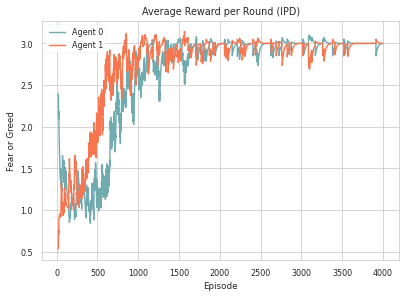

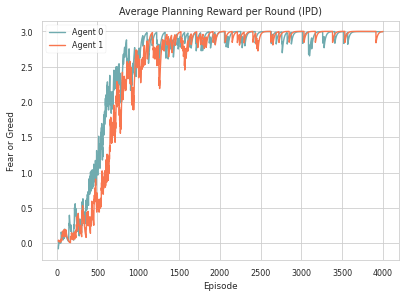

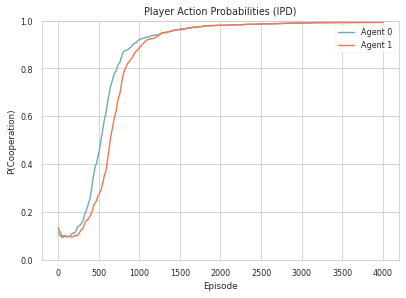

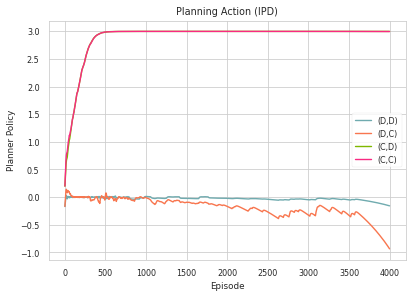

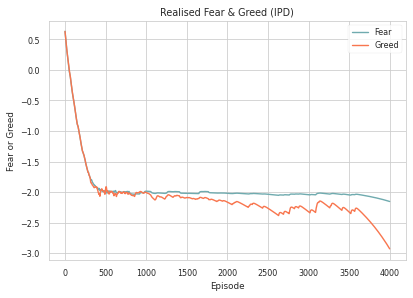

In [12]:
env = IPD()
run(env,
    cost_param=3e-4)

### Without Planner

100%|██████████| 4000/4000 [00:36<00:00, 110.79it/s]


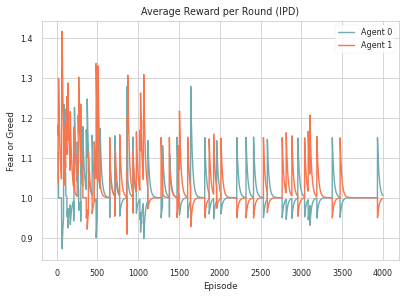

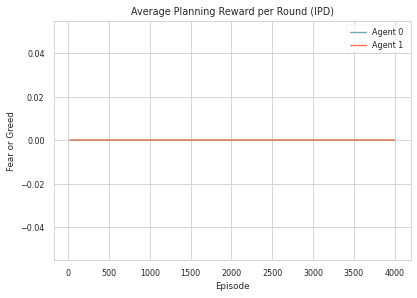

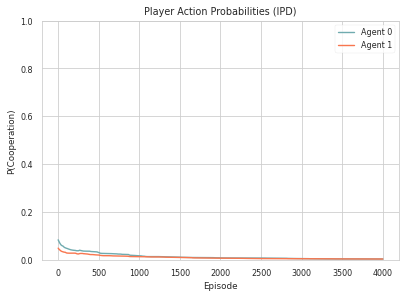

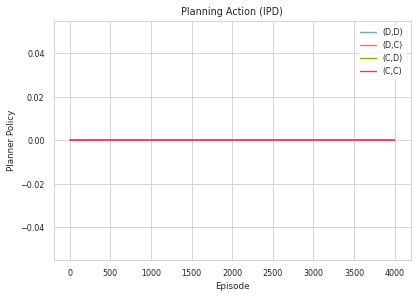

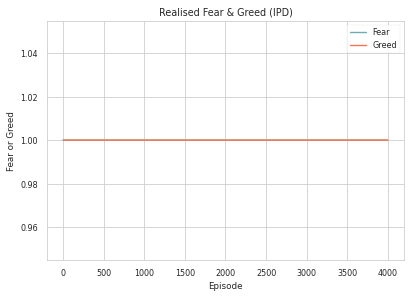

In [13]:
env = IPD()
run(env,
    use_planner=False,
    cost_param=0,
    value_fn_variant='estimated'
   )

## Stag Hunt

### With Planner

100%|██████████| 4000/4000 [00:38<00:00, 103.17it/s]


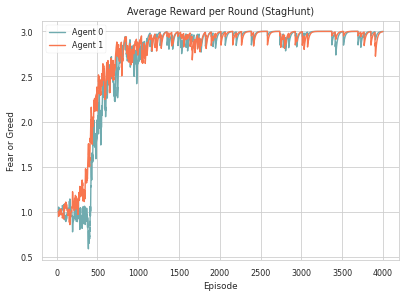

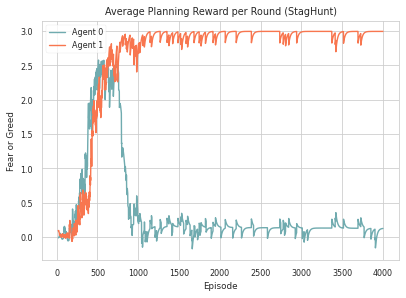

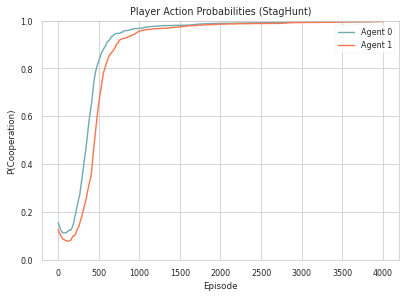

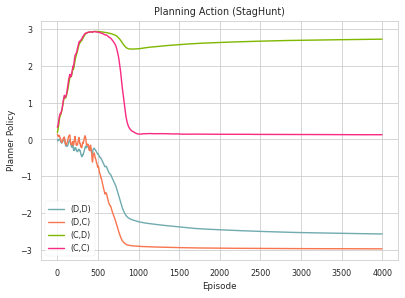

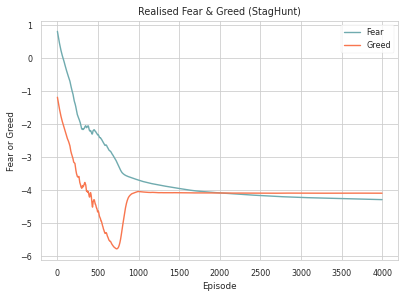

In [14]:
env = StagHunt()
run(env,
    cost_param=0,
   )

### Without Planner

100%|██████████| 4000/4000 [00:36<00:00, 110.29it/s]


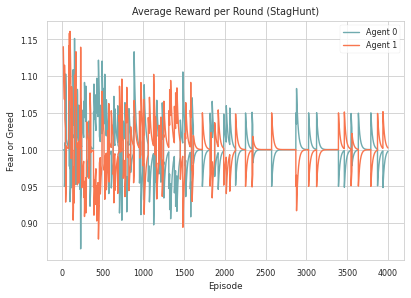

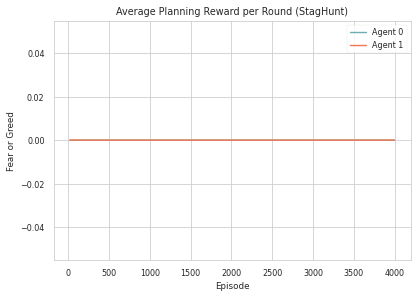

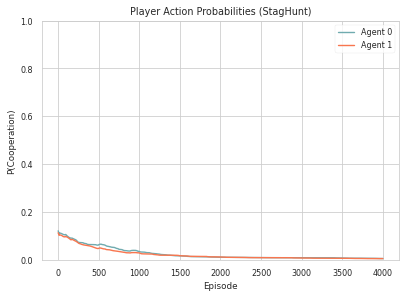

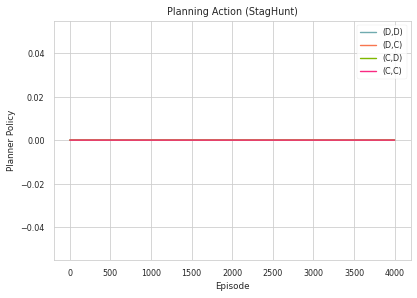

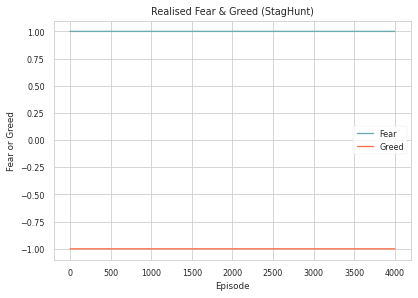

In [15]:
env = StagHunt()
run(env,
    use_planner=False,
    cost_param=0,
    value_fn_variant='estimated'
   )

## Chicken

### With Planner

100%|██████████| 4000/4000 [00:38<00:00, 103.06it/s]


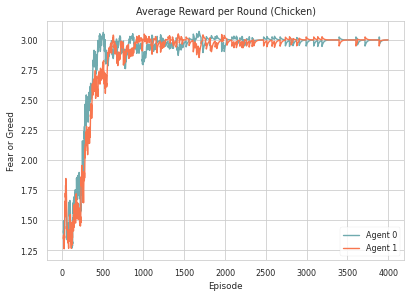

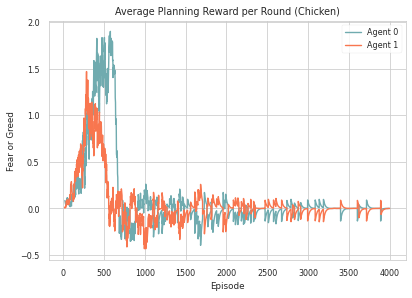

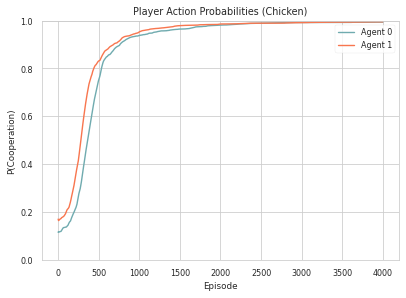

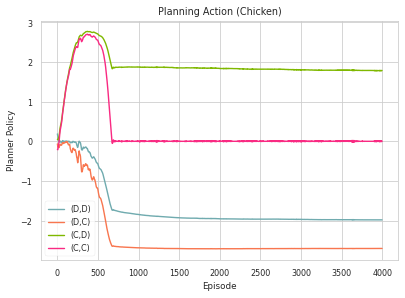

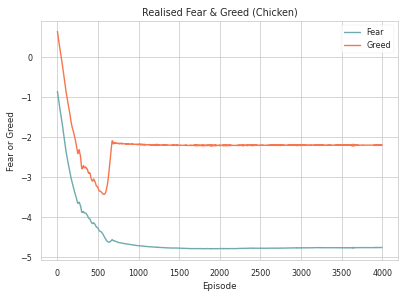

In [16]:
env = Chicken()
run(env,
    cost_param=3e-4)

### Without Planner

100%|██████████| 4000/4000 [00:36<00:00, 111.07it/s]


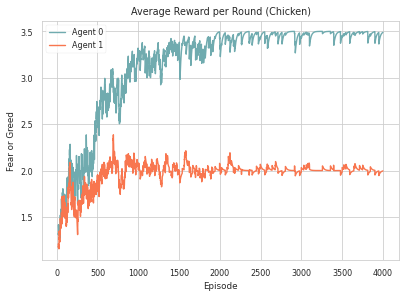

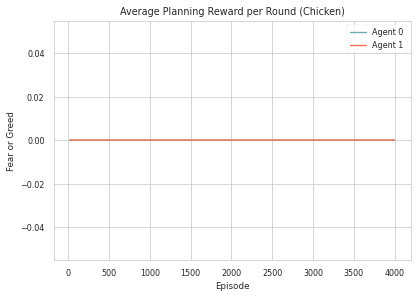

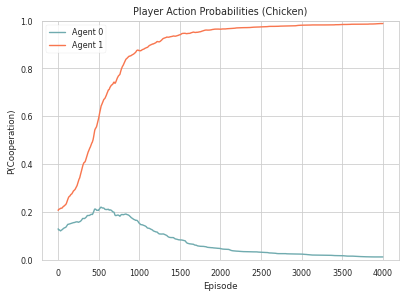

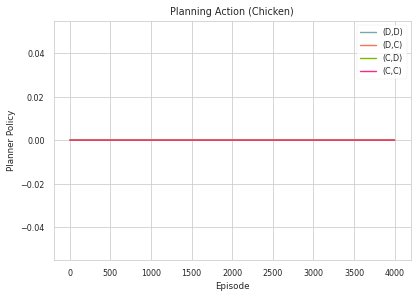

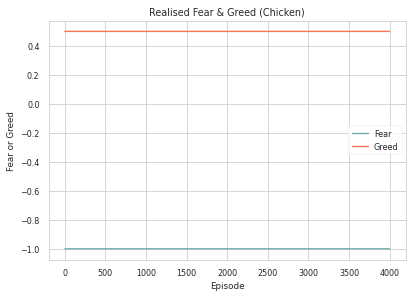

In [17]:
env = Chicken()
run(env,
    use_planner=False,
    cost_param=0,
    value_fn_variant='estimated'
   )